### Data and Library Imports

#### About Data

Dats is fetched from the US Energy Information Administration website whose, at
the moment, active link is [this](https://www.eia.gov/totalenergy/data/browser/index.php?tbl=T02.03#/?f=M&start=200001). 
The data shows the different types of energy consumed by the Commercial sector.
However, in our analysis we will only focus on the Natural Gas consumption. 

In [90]:
# Import Libraries
from itertools import product
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX 
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error as mape
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
import warnings
warnings.filterwarnings(action='ignore')


# For Prophet
from prophet import Prophet
from prophet.plot import plot_plotly
import plotly.offline as py

In [121]:
# Import Dataset
df = pd.read_csv("natural_gas_cons_us.csv", parse_dates=['YYYYMM'])
print(df.shape)
df.head()

### Data Manipulation

In [123]:
"""We are only interested in the "Natural Gas Consumed by the Commercial Sector 
(Excluding Supplemental Gaseous Fuels)" part of the data so we will access the 
needed rows by filtering out the values that have MSN code of NNCCBUS"""

# Filter our the MSN having value 'NNCCBUS'
df_nnccbus = df[df['MSN'] == 'NNCCBUS']

In [58]:
"""As from the output glace, one can see that the date and time is not parsed. The
reason is that some of the data have 13 month which is not possble. After some 
analysis, I found that those are the sum for the whole year. So, first we will 
filter out those values."""

# Filter out the %13 from the 'YYYYMM'
df_nnccbus = df_nnccbus[~df_nnccbus['YYYYMM'].str.endswith('13')]

# Filter out the other columns that we don't need
col_need = ['YYYYMM', 'Value']
df_clean = df_nnccbus[col_need]

print(f"The final shape of the dataset is: {df_clean.shape}")

# Convert the column to date and time format
df_clean.set_index(pd.to_datetime(df_clean['YYYYMM'], format='%Y%m'), inplace=True)

# Removing the 'YYYYMM' column
df_clean.drop(['YYYYMM'], inplace=True, axis=1)

# Converting the 'Value' Column to integer
df_clean['Value'] = pd.to_numeric(df_clean['Value'])

The final shape of the dataset is: (595, 2)


<AxesSubplot: xlabel='YYYYMM'>

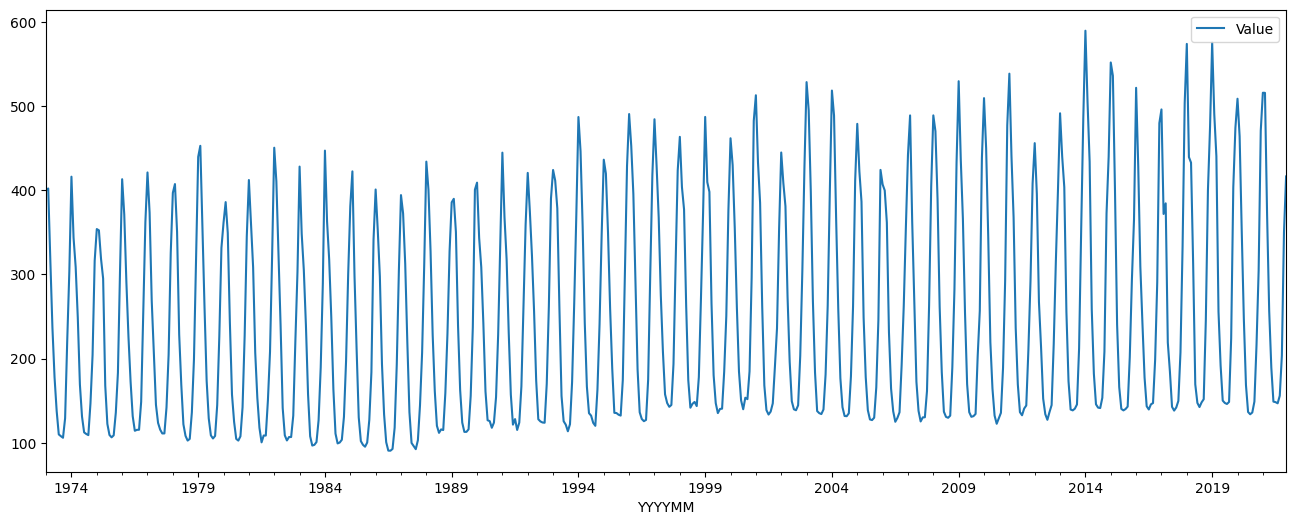

In [124]:
# We will also only take the data for the year till 2021 and remove data-points after year 2022 as it has not complete yearly data.
df_2022 = df_clean[df_clean.index.year >= 2022]

df_clean = df_clean[df_clean.index.year < 2022]

# Plot
df_clean.plot(figsize=(16,6))

In [125]:
# Plotly figure for more interractivity
import plotly.express as px

fig = px.line(df_clean, y=['Value'], x= df_clean.index)
fig.show()

"""From the figure, we can see that the Natural Gas consumed by the commercial
sector is highest in the January and lowest in the July or August showing the 
cyclic pattern yearly"""

'From the figure, we can see that the Natural Gas consumed by the commercial\nsector is highest in the January and lowest in the July or August showing the \ncyclic pattern'

### Time Series Pre-Analysis

'From the graphs, it is clear that there is some incresing trendas well as \nseasonaloty in the data'

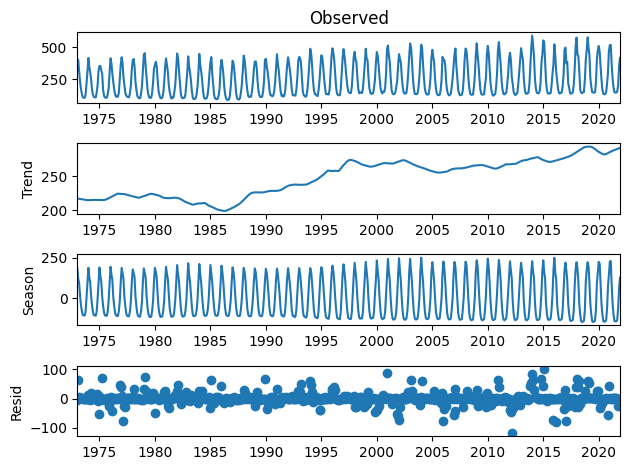

In [126]:
# Time-Series Decomposition using STL to view the seasonality and trend

from statsmodels.tsa.seasonal import STL

decomposed = STL(df_clean, period=12, robust=True)

decomposed_robust = decomposed.fit()
decomposed_robust.plot();

"""From the graphs, it is clear that there is some incresing trendas well as 
seasonaloty in the data"""

In [128]:
"""To built the time-series model through ARIMA and SARIMA, we have the assumtion
about the data to be stationary."""

# Stationarity Test
adf_test = adfuller(df_clean['Value'])

print(f"The P-Value is : {adf_test[1]}");

"""Since the P-value is greater than 0.05, we can't reject the null hypothesis
therefore, the series is not stationary.

If the series is not stationary, then we can do the data transformation to make
the data stationary. One of the common method, is to take the differencing."""

The P-Value is : 0.35427609757536827


"Since the P-value is greater than 0.05, we can't reject the null hypothesis\ntherefore, the series is not stationary.\n\nIf the series is not stationary, then we can do the data transformation to make\nthe data stationary. One of the common method, is to take the differencing."

In [129]:
# 1st order Differencing
diff_1 = df_clean['Value'].diff().dropna().tolist()

# adf test on first order differenced data
adf_test_diff1 = adfuller(diff_1)

print(f"The P-value for first differenced series is: {adf_test_diff1[1]}")

"""The P-Value is less than 0.05 so, reject null hypo. Therefore, the series in now
stationary. 

The d and D for the SARIMAX will be 1. These are the diffrencing factor for the 
late model"""

The P-value for first differenced series is: 1.237243568729077e-17


'The P-Value is less than 0.05 so, reject null hypo. Therefore, the series in now\nstationary. \n\nThe d and D for the SARIMAX will be 1 '

In [31]:
# Seasonal Differencing
seasonal_diff = df_clean['Value'].diff(12).dropna().tolist()

# ADF test on seasonal difference
adf_test_seasonal = adfuller(seasonal_diff)
print(f"The p-value of seasonal_diff data is : {adf_test_seasonal[1]}")

"""The p-value less than 0.05, so the seasonal_diff is 12 (m). This mean we have
seasonality on the yearly basis which can also be easily deducted through the 
graphs"""

The p-value of seasonal_diff data is : 2.0659655177292197e-11


'The p-value less than 0.05, so the seasonal_diff is 12 (m)'

### SARIMA Model

SARIMA is the statistical modeling technique which integrates [Auto-regressive](https://en.wikipedia.org/wiki/Autoregressive_model)
and [Moving Average](https://en.wikipedia.org/wiki/Moving-average_model) model along side accounting for the seasonality. If we remove,
the season factor, we will get the ARIMA model. Therfore, one need to be familiarized
with the ARIMA model to fully understand the SARIMA

In [32]:
"""We will do the grid search to find the optimal parameter for the SARIMA model"""

# List all the components needed for the SARIMAX
d = 1
D = 1
s = 12

ps = range(0,3,1)
qs = range(0,3,1)
Ps = range(0,3,1)
Qs = range(0,3,1)

sarima_order = list(product(ps, qs, Ps, Qs))

In [33]:
# Model the SARIMAX
results = []
for items in sarima_order:
    try:
        model = SARIMAX(df_clean['Value'],
                        order=(items[0], d, items[1]),
                        seasonal_order=(items[2], D, items[3], s),
                        simple_differencing=False).fit(disp=False)
    except:
        continue
    aic = model.aic
    results.append([items, aic])

result_df = pd.DataFrame(results, columns=['(p,q,P,Q)', 'AIC'])


In [34]:
"""From all model, we will choose the model whose AIC score is the lowest."""

# Find the order where we got the lowest value and store the result
print(result_df.sort_values(by='AIC'))

"""As we can see the order (1,1,2,2) resulted in lowest AIC score therefore, 
later we will fit the model with same order."""

       (p,q,P,Q)          AIC
44  (1, 1, 2, 2)  5199.193174
43  (1, 1, 2, 1)  5200.457928
53  (1, 2, 2, 2)  5200.695641
71  (2, 1, 2, 2)  5200.783811
52  (1, 2, 2, 1)  5201.944820
..           ...          ...
9   (0, 1, 0, 0)  5523.081456
54  (2, 0, 0, 0)  5546.069018
3   (0, 0, 1, 0)  5558.111625
27  (1, 0, 0, 0)  5591.343352
0   (0, 0, 0, 0)  5649.148895

[81 rows x 2 columns]


'As we can see the order (1,1,2,2) resulted in lowest AIC score therefore, \nlater we will fit the model with same order.'

In [35]:
# Train-Test Split
"""We will take latest 12 data points as our test set and reamining as our train
set. We took 12 because we want to predict the value for a year"""

train = df_clean[:-12]
test = df_clean[-12:]

In [36]:
# Re-train the model on the optimal order and the train data
"""Here we have used the order (1,1,2,1) insted of (1,1,2,2) because the AIC score
are similar for both model but the latter model has 1 extra number of parameter
then the first one. For instance, for the first one there are total of 5(1+1+2+1) 
parameter wheres for latter one there are 6."""

order = (1,d,1)
seasonal_order = (2,D,1,s)

mdl1 = SARIMAX(train,
                order = order,
                seasonal_order=seasonal_order,
                simple_differencing=False).fit(disp=False)

print(mdl1.summary())

"""From the below summary, we can see the details of our model. I want to focus
on the Ljung-Box where the p-value is not significant(0.97) meaning the data are
independently distributed and doesn't exhibit correlation, which is what we want.

On the other hand, JB test is significant which means the data's residual isn't
normally distributed. We can look at the plot later to find our how much we are
off froma idea normal distribution."""

                                     SARIMAX Results                                      
Dep. Variable:                              Value   No. Observations:                  576
Model:             SARIMAX(1, 1, 1)x(2, 1, 1, 12)   Log Likelihood               -2534.252
Date:                            Wed, 21 Dec 2022   AIC                           5080.504
Time:                                    17:06:33   BIC                           5106.504
Sample:                                01-01-1973   HQIC                          5090.654
                                     - 12-01-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4206      0.036     11.683      0.000       0.350       0.491
ma.L1         -0.9548      0.016   

"\nFrom the below plot we can see that, the standard residual doesn't have any trend and the variance looks constant over time.\n\nThe distribution of the residuals kinda resembles with the normal distribution only it has some peak.\n\nThe normal QQ plot is also somewhat closer to the therotical quantiles.\n\nAt last the correlogram of the residual aren't significant after lag 0.\n\nAll of these factors gives us confident that, our model might be good to forecast.\n\n"

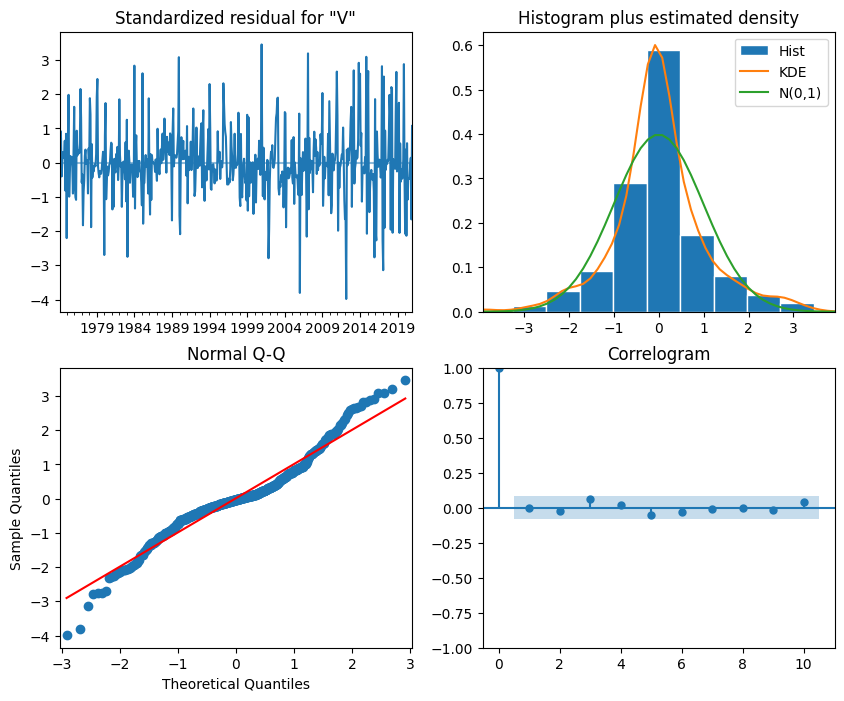

In [38]:
# Diagonistic Plot
mdl1.plot_diagnostics(figsize=(10,8));

"""
From the below plot we can see that, the standard residual doesn't have any trend and the variance looks constant over time.

The distribution of the residuals kinda resembles with the normal distribution only it has some peak.

The normal QQ plot is also somewhat closer to the therotical quantiles or cloaser to normal distribution.

At last the correlogram of the residual aren't significant after lag 0.

All of these factors gives us confident that, our model might be good to forecast.

"""

### AUTO SARIMA
The method of AUTO-SARIMA is same as above manually processed model. However, it
user some techniques to quickly search the correct parameters.The details can be found [here](http://alkaline-ml.com/pmdarima/about.html#about)

In [40]:
mdl_auto = pm.auto_arima(train,
                        seasonal=True,
                        m=12,
                        d=1,
                        D=1,
                        max_P=4,
                        max_Q=4,
                        max_q=4,
                        max_p=4,
                        max_d=2,
                        information_criterion='aic',
                        trace=False,
                        error_action='ignore',
                        stepwise=True,
                        suppress_warnings=True,
                        n_jobs=-1,
                        random_state=112233,)

In [41]:
# Model Summary
print(mdl_auto.summary())

"""From the model diagostic, it can be seen that our SARIMA model with 
order (1,1,1)(0,1,1,12) will acheive the lowest AIC score.

If you compare the AIC score from the previous model to this one, this one has
lower meaning this is better then the above one.

We also see the same kinds of results in the assumption checking tests"""

                                         SARIMAX Results                                          
Dep. Variable:                                          y   No. Observations:                  576
Model:             SARIMAX(1, 1, 1)x(0, 1, [1, 2, 3], 12)   Log Likelihood               -2534.164
Date:                                    Wed, 21 Dec 2022   AIC                           5080.327
Time:                                            17:18:23   BIC                           5106.327
Sample:                                        01-01-1973   HQIC                          5090.477
                                             - 12-01-2020                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4185      0.036     11.493      0

'From the model diagostic, it can be seen that our SARIMA model with \norder (1,1,1)(0,1,1,12) will acheive the lowest AIC score.'

In [42]:
# Making a new model again with SARIMA model with order (1,1,1)(0,1,1,12)
mdl2 = SARIMAX(train,
                order=(1,1,1),
                seasonal_order=(0,1,1,12), 
                seasonal_diff=False).fit(disp=False)

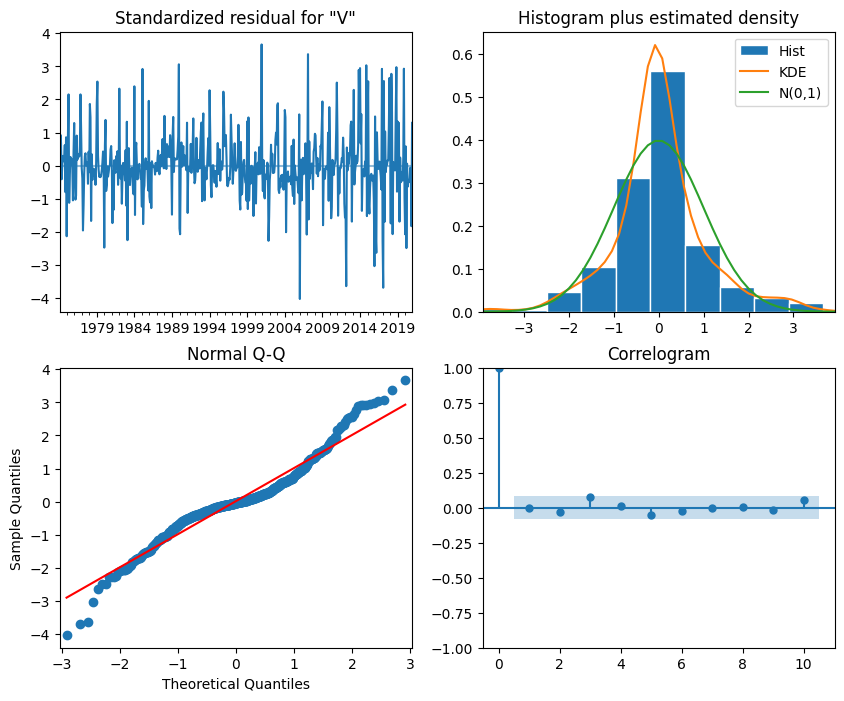

In [130]:
# Model diagnostic plot
mdl2.plot_diagnostics(figsize=(10,8));
"""
From the model diagonstics:

-- The data is almost normal
-- The residual are not correlated as seen in the correlogram plot as well as
    from the Ljung-Box test. The p-value is greater then .05 so fail to reject the
    null hypothesis: the residual are not correlated.
"""

### Forecasting & Comparing

We will use the model from auto-sarima as it came to be better then the manually
built one previously. 

In [131]:
# Get the predicted value for the test data
forecasted_test_date = mdl2.get_forecast(steps=12).summary_frame()

# Glimpse of the data-frame
print(forecasted_test_date.head())

# Calculate the MAPE score of the test data
mape_score = mape(test['Value'], forecasted_test_date['mean'])

print(f"The MAPE of the model is {round(mape_score*100,2)}%")

Value             mean    mean_se  mean_ci_lower  mean_ci_upper
2021-01-01  541.554812  21.899879     498.631838     584.477786
2021-02-01  465.580106  24.313357     417.926802     513.233410
2021-03-01  395.123690  24.937667     346.246761     444.000619
2021-04-01  263.994069  25.158516     214.684283     313.303855
2021-05-01  186.863777  25.267537     137.340314     236.387239
The MAPE of the model is 4.74%


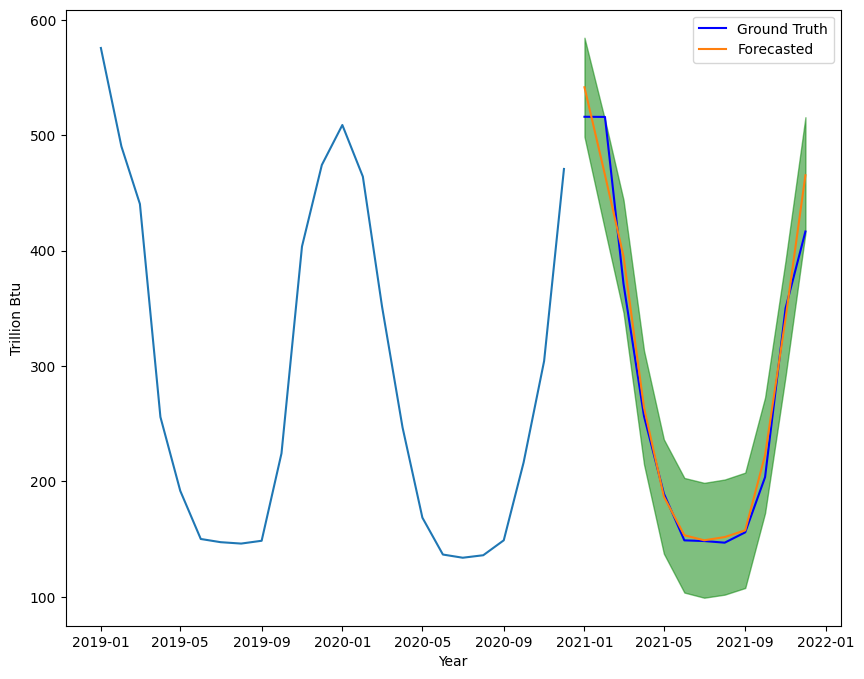

In [132]:
# Forecasting plot for the test data

fig, ax = plt.subplots()

fig.set_size_inches(10,8)
ax.plot(train[train.index.year > 2018].index, train[train.index.year > 2018]['Value'])
ax.plot(test.index, test['Value'], 'b-', label='Ground Truth')
ax.plot(test.index, forecasted_test_date['mean'], label='Forecasted')
ax.fill_between(forecasted_test_date.index, forecasted_test_date['mean_ci_lower'],
                forecasted_test_date['mean_ci_upper'], color='g', alpha=.5,)
ax.set_xlabel("Year")
ax.set_ylabel("Trillion Btu")
ax.legend()
plt.plot();

"""We only showed some part of the plot. From the graph we can see that the model
is performing well as it is fitting the ground truth almost perfectly."""

In [77]:
# Let's also comapare the forcasted the value for the year 2022 that we seperated
# at the initial phase.

# Prediction for the 2022 data points
pred_2022 = mdl2.get_prediction(start='2022-01-01', end='2022-07-01').summary_frame()

# Attach the actual value 
pred_2022['actual'] = df_2022['Value']

# Let's calculate the RMSE for these values
mape_score = mape(pred_2022['actual'], pred_2022['mean'],)

print(f"The MAPE score on the 2022 test data is: {round(mape_score, 3)*100}")

"""Here also we get the similar error results"""

The MAPE score on the 2022 test data is: 3.0


### Prophet Model

Prophet is the forecasting model open sourced by Meta(former Facebook). It is accurate, fast, automatic, robust to outliers etc. 
One of the main advantanges of the Prophet is it has very few paramters to be tweaked. Moroever, it doesn't rely heavily on the assumptions like the classical ARIMA and SARIMA models. 

In [92]:
"""We will use the same train data for the modeling and testing for performance.
Prophet takes dependent variable as 'y' as independent as 'ds', therefore we have
to make sure the column name matches."""

# Data Preparation
df_prophet_train = pd.DataFrame({'ds': train.index, 'y': train['Value']})
df_prophet_train.reset_index(drop=True, inplace=True)

# Also do the same for test data
df_prophet_test = pd.DataFrame({'ds': test.index, 'y': test['Value']})
df_prophet_test.reset_index(drop=True, inplace=True)

In [104]:
# Prophet Modeling
prop_mdl = Prophet(interval_width=0.95, weekly_seasonality=False, daily_seasonality=False)
prop_mdl.fit(df_prophet_train)

20:52:21 - cmdstanpy - INFO - Chain [1] start processing
20:52:21 - cmdstanpy - INFO - Chain [1] done processing


In [133]:
# Evaluation on Testing Data
pred_prop = prop_mdl.predict(df_prophet_test)

# MAPE
prop_err = mape(test['Value'], pred_prop['yhat'])

print(f"MAPE (Prophet): {round(prop_err*100,3)}%")

"""The MAPE for Prophet is higher then the SARIMA model suggesting that SARIMA is
working better then the Prophet."""

MAPE (Prophet): 10.057%


'The MAPE for Prophet is higher then the SARIMA model suggesting that SARIMA is\nworking better then the Prophet.'

### Conclusion

In this project we forecasted the energy consumption of natural gas by the commercial sector. The data is openly available on the earlier mentioned website. We have monthly data starting from the year 1973 to the current. We also saw strong seasonality in the data on yearly basis. Therfore, we decided to model the SARIMA for the forecasting. With the grid search, we were able to find the optimal parameter for the model. Moreover, we also user auto-sarima to automatically find the optimal parameter. The auto-sarima model was more accurate. 

Additionally, we also user Prophet which is very easy to use and conifigure. However, it, didn't performed better then the SARIMA model. In some literature, it has been found that Prophet sometimes isn't the best choice [Menuculini et.al 2021](https://arxiv.org/pdf/2107.12770.pdf)